# 4. How to Replace Raster Cell Values with Values from A Different Raster Data Set 

#### Replace (masked) values in one xarray DataArray with values in another array.

Sometimes you have many bad pixels in a landsat scene that you wish to replace or fill in with pixels from another scene. In this lesson you will learn how to replace pixels in one scene with those from another using Xarray.

To begin, open both of the pre-fire raster stacks. You got the cloud free data as a part of your homework, last week. The scene with the cloud is in the cold spring fire data that you downloaded last week.

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ma
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
import pyproj
import geopandas as gpd
pyproj.set_use_global_context(True)

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
data_2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

Extracted output to C:\Users\34639\earth-analytics\data\cs-test-landsat\.


In [2]:
def check_crs(raster_path):
    """
    Returns the CRS of a raster file.

    Parameters
    ----------
    raster_path : string
        A path to a raster file that you wish to check the crs of. Assuming
        this is a tif file.

    Returns
    -------
    A crs object

    """

    with rio.open(all_landsat_post_bands[0]) as src:
        return src.crs


def open_clean_band(band_path, crop_layer=None, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)

    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band


def process_bands(paths, crop_layer=None, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).

    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.

    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

Open and process your data.

In [3]:
# Open pre fire Landsat data
landsat_dirpath_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-4]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))

landsat_pre = process_bands(landsat_paths_pre, stack=True)
landsat_pre

I'm stacking your data now.


<xarray.DataArray (band: 3, y: 177, x: 246)>
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

In [4]:
# Mask cloudy pixels
landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Mask the data using the pixel QA layer
landsat_pre_cl_masked = landsat_pre.where(~landsat_qa.isin(all_masked_values))

Plot the data to ensure that the cloud covered pixels are masked.

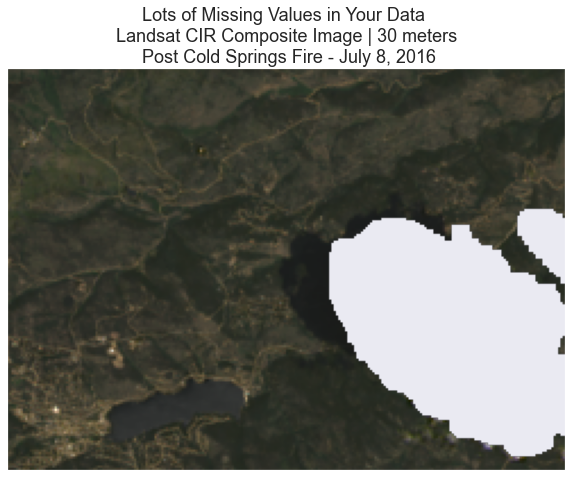

In [5]:
# Plot data
# Mask NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cl_free_plot = ma.masked_array(landsat_pre_cl_masked.values,
                                           landsat_pre_cl_masked.isnull())

# Plot
ep.plot_rgb(landsat_pre_cl_free_plot,
            rgb=[2, 1, 0],
            title="Lots of Missing Values in Your Data \n Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire - July 8, 2016")
plt.show()

Next, read in and stack the cloud free landsat data. **Below you access the bounds object of a rioxarray object with xarray_name.rio.bounds()**. This contains the spatial extent of the cloud free raster. You will use this to ensure that the bounds of both datasets are the same before replacing pixel values.

#### Clip Your Cloud Free Landsat Scene to the Same Extent
Below you create a clip extent of your cloud covered seen to use to crop the cloud free scene. This crop step is important to ensure that pixels overlap and to further reduce memory needed to process your data.

<AxesSubplot:>

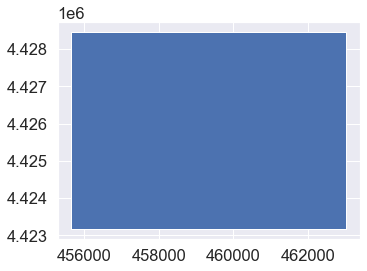

In [13]:
# Create bounds object to clip the cloud free data
landsat_pre_cloud_ext_bds = landsat_pre.rio.bounds()

df = {'id': [1],'geometry': box(*landsat_pre.rio.bounds())} # selext landsat img extent
clip_gdf = gpd.GeoDataFrame(df, crs=landsat_pre.rio.crs) # df to gdf
clip_gdf.plot()

In [8]:
df

{'id': [1], 'geometry': <shapely.geometry.polygon.Polygon at 0x24b6e24e3a0>}

In [26]:
# Read in the "cloud free" landsat data that you downloaded as a part of your homework
cloud_free_path = os.path.join("cs-test-landsat", 
                                "*band[2-4]*.tif")
landsat_paths_pre_cloud_free = sorted(glob(cloud_free_path))
landsat_pre_cloud_free = process_bands(landsat_paths_pre_cloud_free, 
                                       stack=True, 
                                       crop_layer=clip_gdf)

landsat_pre_cloud_free

I'm stacking your data now.


<xarray.DataArray (band: 3, y: 177, x: 246)>
array([[[590., 629., 636., ..., 218., 234., 283.],
        [546., 580., 598., ..., 248., 270., 314.],
        [484., 503., 506., ..., 284., 325., 348.],
        ...,
        [434., 431., 438., ..., 290., 291., 303.],
        [441., 490., 478., ..., 292., 312., 313.],
        [340., 278., 297., ..., 299., 334., 337.]],

       [[781., 808., 828., ..., 461., 485., 535.],
        [748., 795., 807., ..., 491., 519., 574.],
        [727., 754., 743., ..., 535., 590., 627.],
        ...,
        [722., 724., 722., ..., 550., 554., 569.],
        [706., 777., 756., ..., 546., 577., 591.],
        [578., 484., 500., ..., 548., 590., 607.]],

       [[770., 839., 845., ..., 331., 363., 412.],
        [730., 793., 812., ..., 379., 421., 479.],
        [657., 692., 691., ..., 441., 522., 573.],
        ...,
        [697., 789., 797., ..., 497., 486., 505.],
        [837., 788., 802., ..., 476., 505., 508.],
        [542., 477., 465., ..., 510., 536., 536.]]])
Coordinates:
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * band         (band) int64 1 2 3
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     band 2 surface reflectance

### Spatial Extent Check
In order to replace pixel values, you will need to ensure that the spatial extent or boundaries of each dataset are the same. Below you check the
bounds of each object.

In [15]:
# Are the bounds the same for both datasets?
landsat_no_clouds_bds = landsat_pre_cloud_free.rio.bounds()
landsat_pre_cloud_ext_bds = landsat_pre.rio.bounds()
print("The cloud free data bounds are:", landsat_no_clouds_bds)
print("The original cloud covered data bounds are:",  landsat_pre_cl_masked.rio.bounds())
print("Are the bounds the same?", landsat_no_clouds_bds == landsat_pre_cloud_ext_bds)

The cloud free data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
The original cloud covered data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
Are the bounds the same? True


If the bounds of each dataset are different. Thus you will want to clip each scene to ensure the data line up properly when you fill in the pixels of the cloud covered data.

Below you do two things:

- 1.You create a box geometry using the extent of each layer. You will use this to crop your data.
- 2.You then check again to ensure both layers overlap spatially,

In [18]:
# Create polygons from the bounds
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)

# Do the data overlap spatially?
cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

Below you plot the boundaries. This is an optional step that simply shows you that the extent of the cloud covered data is much smaller compared to the cloud free scene. You will want to clip the cloud free scene to the extent of the cloud covered scene to make them align.

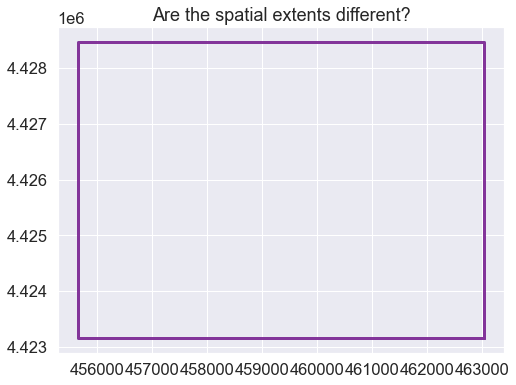

In [19]:
# Plot the boundaries
x, y = cloud_free_scene_bds.exterior.xy
x1, y1 = cloudy_scene_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.plot(x1, y1, color='purple', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.set_title('Are the spatial extents different?')

plt.show()

Overlapping spatial extents of the masked Landsat image and the image that will be used to fill in the masked values.

In [21]:
# Is the CRS the same in each raster?
landsat_pre.rio.crs == landsat_pre_cloud_free.rio.crs

True

In [22]:
# Are the shapes the same?
landsat_pre.shape == landsat_pre_cloud_free.shape

True

You’ve now determined that

- 1.the data have the same bounds
- 2.the data are in the same Coordinate Reference System and
- 3.the data do overlap (or intersect).

Because you clipped the data above, you don’t need to do any additional cleanup. However if your data did have different spatial extents or CRS’s you would have to do some more cleanup.

## Replace Cell Values
You are now ready to replace values using **xarray’s where() function**.

In [23]:
# Get the mask layer from the pre_cloud data
mask = landsat_pre_cl_masked.isnull()

# Assign every cell in the new array that is masked
# to the value in the same cell location as the cloud free data
landsat_pre_clouds_filled = xr.where(mask, landsat_pre_cloud_free, landsat_pre_cl_masked) # xarray.where(cond, x, y) (C, T, F)
landsat_pre_clouds_filled                                                                    # x (scalar, array, Variable, DataArray or Dataset) – values to choose from where cond is True

<xarray.DataArray (band: 3, y: 177, x: 246)>
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]]])
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 0

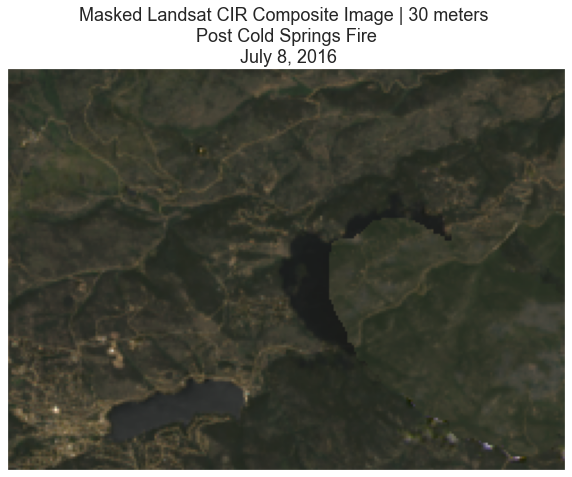

In [25]:
# Mask NA values with to plot with ep.plot_rgb
landsat_pre_clouds_filled_ma = ma.masked_array(landsat_pre_clouds_filled.values,  # numpy as ma   https://numpy.org/doc/stable/reference/maskedarray.generic.html
                                                            landsat_pre_clouds_filled.isnull())

ep.plot_rgb(landsat_pre_clouds_filled_ma,
            rgb=[2, 1, 0],
            title="Masked Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()

Landsat CIR Composite image after replacement of masked pixel values using a cloud-free image for the post-Cold Springs fire.

The above answer is not perfect! You can see that the boundaries of the masked area are still visible. Also there are dark shadowed pixels that were not replaced given the raster pixel_qa layer did not assign those as pixels to be masked. Thus you may need to do a significant amount of further analysis to get this image to where you’d like it to be. But you at least have a start at getting there!